# Script to produce CCA S2S forecasts and assess associated skill
# --CFSv2 version
#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu) and Andrew W. Robertson (awr@iri.columbia.edu) 

#### Acknowledgements (some Python functions and Ingrid code): 
Remi Cousin, James Doss-Gollin

#### Version info
* This version is PyCPTv1-CFSv2-TRMM, modified by AGM
* Previous version: 17 Jul 2018, Modified by AWR
* First version: 12 Dec 2017; First IPython version (Jupyter Notebook), 24 Jun 2018

#### Input:
* Predictor is rainfall from CFSv2 (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7)

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!
2. Weekly initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.


### Namelist section
----------------------

In [1]:
# Forecast date
mon='Jul' 	# Forecast month 
fyr=2018 	# Forecast year
fday=31 	# Forecast day  (Yesterday in real time)
training_season='Jun-Aug'

hstep = 3 # use all starts in the trainng period with this daily step between them (v5 used 7)
nlag = 3  # length of the lagged ensemble in days
ntrain = 371  # Length of training period
nwk= 2 # Number of weeks (leads)
force_download=False   #force download of data files, even if they already exist locally

# Rainfall frequency switch (False gives total rainfall for forecast period)
rainfall_frequency = True
# Wet day threshold (mm)
wetday_threshold = 3

# GrADS plotting switches True/False
# If first switch is False, output will be in CPTv10 format  
grads_plot = True
grads_plot_forecasts = True
grads_plot_skill = True

# Spatial domain for predictor
nla1=30 	# Northernmost latitude
sla1=-5 	# Southernmost latitude
wlo1=-100 	# Westernmost longitude
elo1=-48 	# Easternmost longitude
# Spatial domain for predictand
nla2=30 	# Northernmost latitude
sla2=-5 	# Southernmost latitude
wlo2=-100 	# Westernmost longitude
elo2=-48 	# Easternmost longitude

# Working directory
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas/'

# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/15.7.6/'

# S2S Database key
%cd $workdir
with open('.IRIDLAUTH') as file:
    authkey = file.read() 

/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas


In [2]:
# Forecast lead interval
# Lists for looping over lead times
#wk = [1,2,3,4,34]  # week-lead number label (week1, week2, week3-4)
#day1 = [3,10,17,24,17]  # first lead day of target weeks 
#day2 = [9,16,23,30,30]  # last lead day of target weeks 

wk = [3,4,34]  # week-lead number label (week1, week2, week3-4)
day1 = [17,24,17]  # first lead day of target weeks 
day2 = [23,30,30]  # last lead day of target weeks 

# Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

### End of namelist section  (do not modify anything below this line)
----------------------

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
from pycpt_functions import *

In [4]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold))
else:
    print('Predictand is Rainfall Total')
    
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")

Predictand is Rainfall Frequency; wet day threshold = 3
Creating working folders, if not already there...
Work directory is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to namelist and modify domains

Forecast date is 31 Jul 2018

     July 2018
Mo Tu We Th Fr Sa Su
                   1
 2  3  4  5  6  7  8
 9 10 11 12 13 14 15
16 17 18 19 20 21 22
23 24 25 26 27 28 29
30 31

    August 2018
Mo Tu We Th Fr Sa Su
       1  2  3  4  5
 6  7  8  9 10 11 12
13 14 15 16 17 18 19
20 21 22 23 24 25 26
27 28 29 30 31



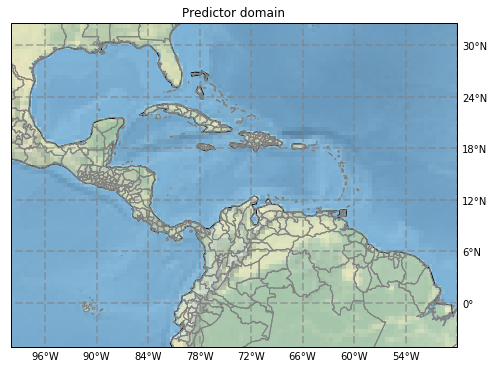

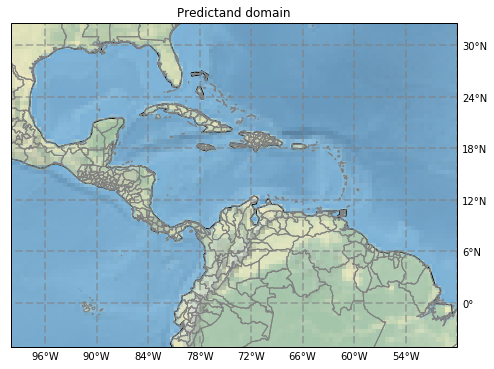

In [19]:
pltdomain(wlo1,elo1,nla1,sla1,'Predictor domain')
pltdomain(wlo2,elo2,nla2,sla2,'Predictand domain')

#Print calendars
print('Forecast date is '+str(fday)+' '+mon+' '+str(fyr))
print('')
c=calendar.TextCalendar(calendar.MONDAY)
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)))
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)+1))

## Download data if necessary, and run CPT

In [27]:
for L in range(nwk):
   nday=day2[L]-day1[L]+1	# Length of target period (days) 
   print("New folder:")
   %cd $workdir/input
   GetHindcasts(wlo1, elo1, sla1, nla1, day1[L], day2[L], mon, os, authkey, wk[L], nlag, training_season, hstep, force_download)
   print('Hindcasts file ready to go')
   if rainfall_frequency: 
        GetObs_RFREQ(day1[L], day2[L], mon, nday, authkey, wk[L], wetday_threshold, nlag, training_season, hstep, force_download)
        print('Obs:rfreq file ready to go')
   else:
        GetObs(day1[L], day2[L], mon, nday, authkey, wk[L], nlag, training_season, hstep, force_download)
        print('Obs:precip file ready to go')
   GetForecast(day1[L], day2[L], fday, mon, fyr, nday, wlo1, elo1, sla1, nla1, authkey, wk[L], nlag, force_download)
   print('Forecasts file ready to go')
 
   print("New folder:")
   %cd $workdir/scripts

   wkf=wk[L]
   CPTscript(mon,fday,wkf,nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,training_season,ntrain,rainfall_frequency,grads_plot)

   print('Executing CPT for Week '+str(wk[L])+'... This might take a while...')
   os.system(cptdir+'CPT.x < params > CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt')
   print('----------------------------------------------')
   print('Week '+str(wk[L])+' calculations completed! See output folder, and check scripts/CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt for errors')
   print('----------------------------------------------')
   print('----------------------------------------------')



New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas/input
Hindcasts file ready to go
Obs:rfreq file ready to go
Forecasts file ready to go
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas/scripts
Executing CPT for Week 3... This might take a while...
----------------------------------------------
Week 3 calculations completed! See output folder, and check scripts/CPT_stout_train_Jun-Aug_Jul_31_wk3.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas/input
OS error: [Errno 2] No such file or directory: 'model_precip_Jul_wk4.tsv'
Hindcasts file doesn't exist --downloading

 Hindcasts URL: 

 http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.NCEP/.reforecast/.perturbed/.sfc_precip/.tp/S/-2/1/0/shiftdatashort/%5BS_lag/M%5Daverage/3./mul/SOURCES/.ECMWF/.S2S/.NCEP/.reforecast/.control/.

## Skill maps

New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas/output
----------------------------------------------
Week: 3
----------------------------------------------


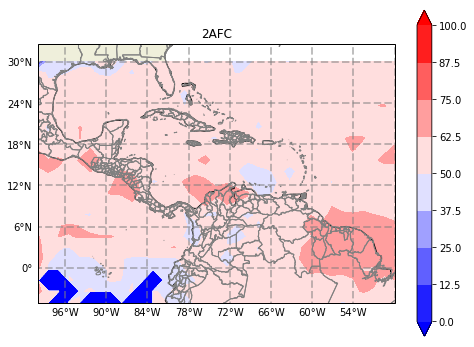

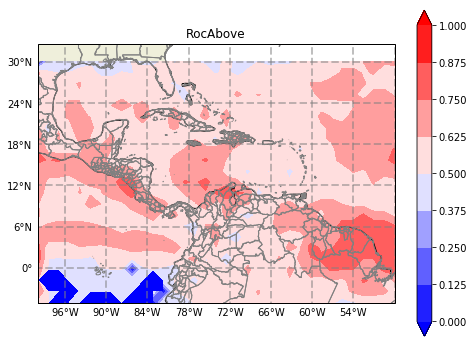

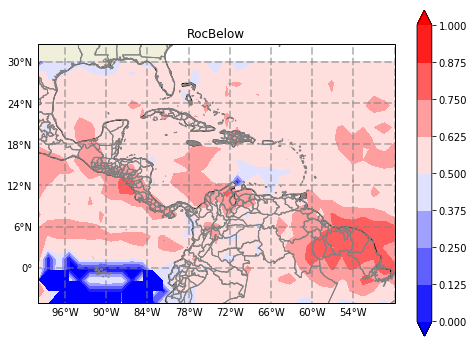

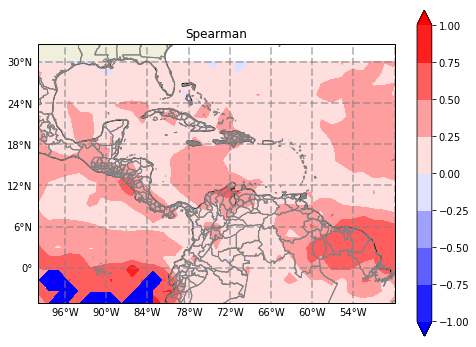

----------------------------------------------
Week: 4
----------------------------------------------


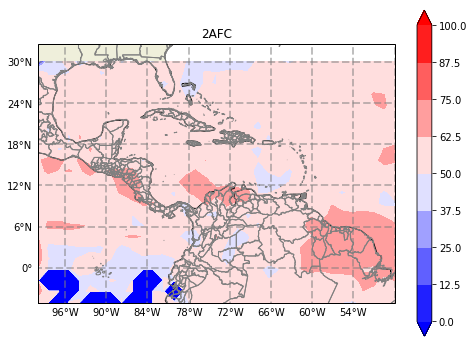

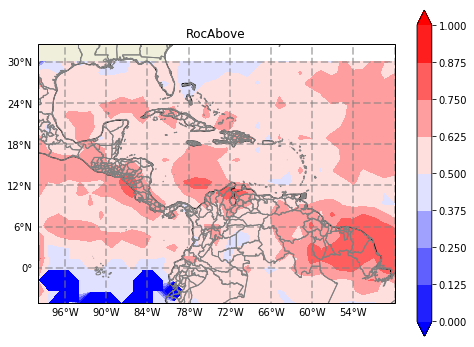

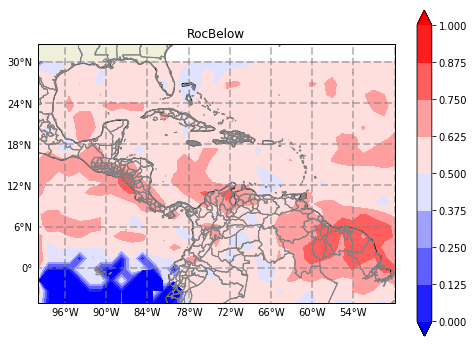

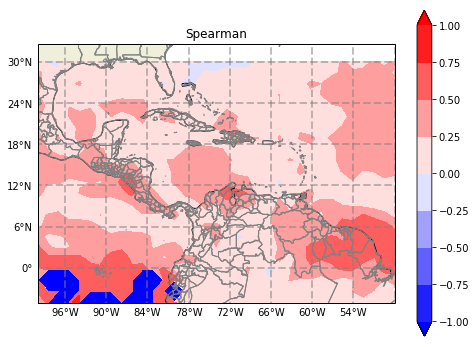

In [5]:
print("New folder:")
%cd $workdir/output

# Desired skill score, choose from: Spearman, 2AFC, RocAbove, RocBelow
for L in range(nwk):
    wkf=wk[L]
    print('----------------------------------------------')
    print('Week: '+str(wkf))
    print('----------------------------------------------')
    pltmap('2AFC',wlo2,elo2,nla2,sla2,fprefix,training_season, mon, fday, wkf)    
    pltmap('RocAbove',wlo2,elo2,nla2,sla2,fprefix,training_season, mon, fday, wkf)
    pltmap('RocBelow',wlo2,elo2,nla2,sla2,fprefix,training_season, mon, fday, wkf)
    pltmap('Spearman',wlo2,elo2,nla2,sla2,fprefix,training_season, mon, fday, wkf)

## Forecast maps

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/IntraAmericas/output
----------------------------------------------
Week: 3
----------------------------------------------


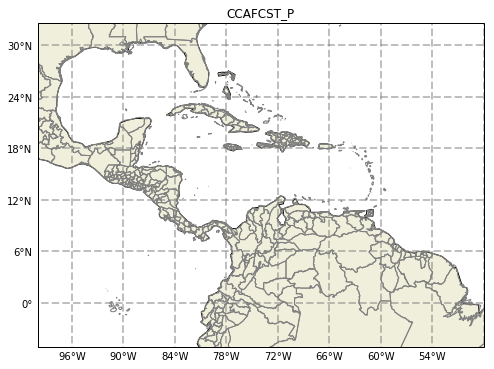

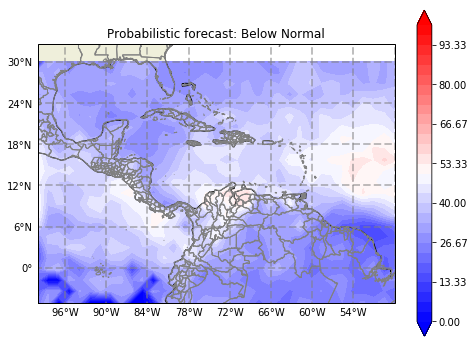

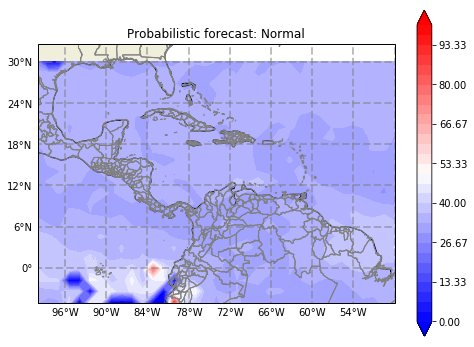

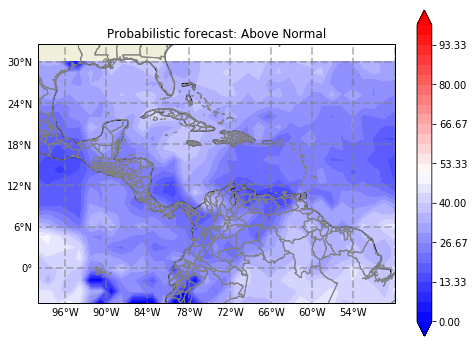

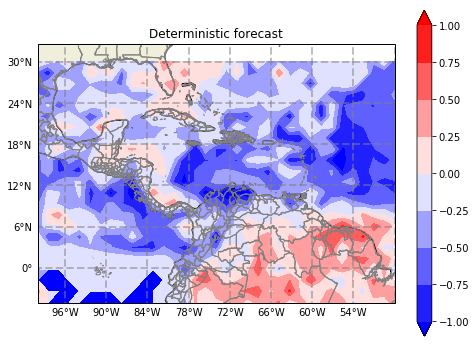

----------------------------------------------
Week: 4
----------------------------------------------


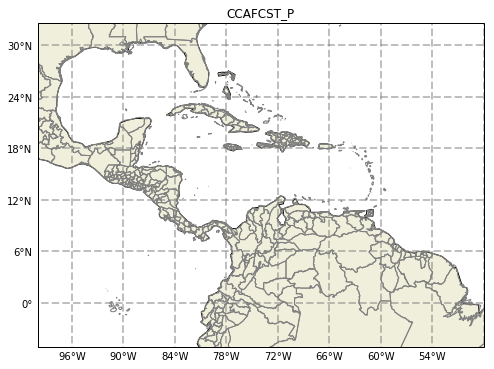

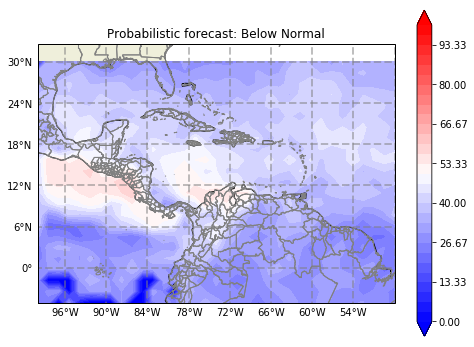

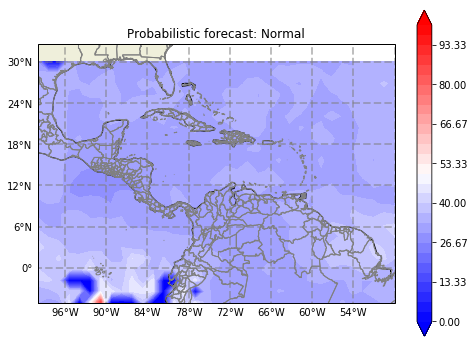

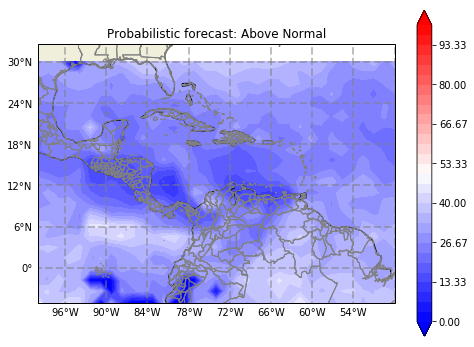

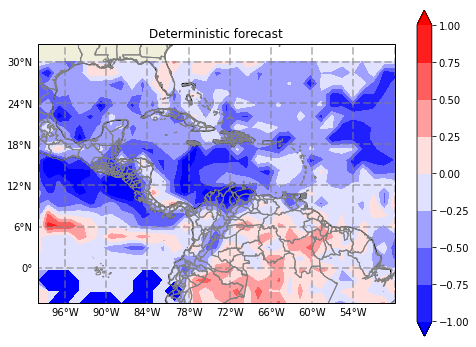

In [5]:
print("Folder:")
%cd $workdir/output
for L in range(nwk):
    wkf=wk[L]
    print('----------------------------------------------')
    print('Week: '+str(wkf))
    print('----------------------------------------------')
    pltmap('CCAFCST_P',wlo2,elo2,nla2,sla2,fprefix,training_season, mon, fday, wkf)
    pltmap('CCAFCST_V',wlo2,elo2,nla2,sla2,fprefix,training_season, mon, fday, wkf)